-----
# cartoGRAPHs
precalculated large networks , e.g. the Interactome

A Notebook to produce 2D and 3D network layouts from any Graph,
including interactive visualization (html files) and export functions 
to import into the VRNetzer analytics platform by Pirch et al.

-----

In [1]:
from cartoGRAPHs import * 

from func_load_data import *
from func_visual_properties import * 
from func_calculations import * 
from func_embed_plot import * 
from func_exportVR import * 

_____
# 1 | DEFINE NETWORK
_____

In [2]:
# ---------------------------------------------------------------------------
#
# PREPROCESSED INFORMATION of organisms e.g. homo sapiens, saccharomyces cerevisiae 
#
# ---------------------------------------------------------------------------
#
# CHOOSE ONE ORGANISM
#
#organism = 'yeast'
organism = 'human'
#
# ---------------------------------------------------------------------------

G = load_graph(organism)

d_centralities = load_centralities(G, organism)
df_centralities = pd.DataFrame(d_centralities).T
df_centralities.columns = ['degree','closeness', 'betweeness', 'eigenvector']
essential_genes,non_ess_genes,notdefined_genes = load_essentiality(G, organism)

d_gene_sym = load_genesymbols(G, organism)
l_features = list(d_gene_sym.values())

# Human specific > to include Disease Ontology
if organism == 'human':
    d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
    d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
    d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
    d_names_do = {y:x for x,y in d_do_names.items()}
else: 
    pass

In [3]:
# ---------------------------------------------------------------------------
#
# PRECALCULATED MATRICES 
# choose one of the following netlayouts (e.g. local,global,importance,..)
#
# ---------------------------------------------------------------------------

#netlayout = 'global' #'local' #'global' #'funct-bio' #'funct-mol' #'funct-cel' #'funct-dis'
#DM = load_datamatrix(G,organism, netlayout)

#genes = []
#for i in DM.index:
#    if i in G.nodes():
#        genes.append(i)
    
#genes_rest = [] 
#for i in G.nodes():
#    if i not in genes:
#        genes_rest.append(i)

In [4]:
DM_cent = load_datamatrix(G,organism, 'importance')
DM_cent_mod = DM_cent.round(4)

_____ 
# 2 | SPATIAL EMBEDDING
_____
Note: Based on Matrix (i.e. variable DM) the network layout type is determined, e.g. local,global,importance, etc. 

Layout Maps to choose from: 
+ Portrait 2D 
+ Portrait 3D 
+ Topographic Map
+ Geodesic Map 

### 2D PORTRAIT

In [10]:
%%time 

posG_tsne2D = layout_portrait_tsne(G,DM,2,prplxty=10, density=1, l_rate=200, steps=250, metric='cosine') 
posG = posG_tsne2D

CPU times: user 26min 31s, sys: 19.1 s, total: 26min 51s
Wall time: 4min 6s


In [5]:
%%time 

posG_umap2D = layout_portrait_umap(G,DM_cent_mod,2,n_neighbors=12, spread=12, min_dist=0.9, metric='cosine') 
#posG_umap2D = layout_portrait_umap(G,DM_mod,2,n_neighbors=20, spread=1, min_dist=0.0, metric='cosine') 
posG = posG_umap2D

/users/christiane.huetter/miniconda3/envs/myenv_clip2/lib/python3.6/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



CPU times: user 1min 30s, sys: 9.36 s, total: 1min 39s
Wall time: 1min 13s


### 3D PORTRAIT 

In [ ]:
%%time 

posG_tsne3D_ = layout_portrait_tsne(G,DM,3,prplxty=10, density=1, l_rate=200, steps=250, metric='cosine') 
posG = posG_tsne3D

In [ ]:
%%time 

posG_umap3D = layout_portrait_umap(G,DM,3,n_neighbors=20, spread=1, min_dist=0.0, metric='cosine') 
posG = posG_umap3D

____________
# 3 | VISUAL SETTINGS + PLOT PREPARATION
____________
+ colors in hex: https://htmlcolorcodes.com/

#### NODES - GENERAL

In [18]:
opacity_nodes = 0.8
node_edge_col = '#696969' 

scale_factor = 0.005
size = list(draw_node_degree(G, scale_factor).values())

scale_factor3D = 0.025
size3d = list(draw_node_degree_3D(G, scale_factor3D).values())

nodesglow_diameter = 8.0
nodesglow_transparency = 0.01 # 0.01

#### NODE COLORS - specific

OPTION 1 - diverse color methods

In [19]:
# ---------------------------------------------------------------------------
#
# Choose a color_method e.g. closeness, essentiality, oocyte, 2cell,4cell,8cell
#
# ---------------------------------------------------------------------------
color_method = 'essentiality'
# ---------------------------------------------------------------------------

if color_method == 'closeness':
    
    l_genes = list(G.nodes())
    
    d_clos = {}
    for k,v in d_centralities.items():
        d_clos[k] = v[1]

    d_nodecolors = d_clos 
    col_pal = 'YlOrRd'

    d_colors = color_nodes_from_dict(G, d_nodecolors, palette = col_pal)
    colors = list(d_colors.values())
    
    edge_color = '#ACACAC'
    width_edges = 0.25
    opacity_edges = 0.1
    
    if len(list(posG.values())[0]) == 2:
        umap_nodes = get_trace_nodes_2D(posG, l_features, colors, size, opacity_nodes)
        umap_edges = get_trace_edges_2D(G, posG, edge_color, opac = opacity_edges)
        data = [umap_edges, umap_nodes]

    elif len(list(posG.values())[0]) == 3:
        umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size, opacity_nodes)
        umap_edges = get_trace_edges_3D(G, posG, edge_color, opac = opacity_edges)
        data = [umap_edges, umap_nodes]
        
    else: 
        print('Please pass node positions for 2- or 3D (e.g. dict with nodeID:(x,y) or nodeID:(x,y,z)') 
    
elif color_method == 'essentiality':
    
    l_genes = essential_genes
    
    node_col = '#00abff' 
    undefined_col = '#d3d3d3'
    rest_col_nodes = '#d3d3d3'

    d_col_all = color_nodes_from_list(G, essential_genes, node_col)
    colors = list(d_col_all.values())
    
    edge_color = node_col 
    d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)
    width_edges = 0.25
    opacity_edges = 0.25
    

    # Choose edges to highlight that link inbetween 2 essential genes only 
    d_edge_col = color_edges_from_nodelist_specific(G, essential_genes, node_col)

    # Rest edges 
    d_rest_edges={}
    for e in G.edges():
        if e not in d_edge_col.keys():
            d_rest_edges[e] = '#ACACAC'

    d_all_edges = {**d_edge_col, **d_rest_edges}
    d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
    edge_color = list(d_all_edges_sort.values())
    
    
    if len(list(posG.values())[0]) == 2:
        umap_nodes = get_trace_nodes_2D(posG, l_features, colors, size, opacity_nodes)
        umap_edges = get_trace_edges_specific2D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)
        data = [umap_edges, umap_nodes]

    elif len(list(posG.values())[0]) == 3:
        umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size, opacity_nodes)
        umap_edges = get_trace_edges_specific3D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)
        data = [umap_edges, umap_nodes]

    else: 
        print('Please pass node positions for 2- or 3D (e.g. dict with nodeID:(x,y) or nodeID:(x,y,z)') 
        
        
elif color_method == 'oocyte' or color_method == '2cell' or color_method == '4cell' or color_method == '8cell':

    node_col = '#0000ff' 
    devgenes_selection = color_method
    df_devgenes = pd.read_csv('input/EmExplorer/'+devgenes_selection+'_Homo-sapiens.txt', delimiter = "\t")
    
    devgenes = list(df_devgenes['stage'])

    d_devgenes_entrezid = {}
    for i,k in d_gene_sym.items():
        if k in devgenes:
             d_devgenes_entrezid[k] = i 
    devgenes_entrezid = list(d_devgenes_entrezid.values())
    
    l_genes = devgenes_entrezid
    
    d_col_all = color_nodes_from_list(G, l_genes, node_col)
    colors = list(d_col_all.values())

    edge_color = node_col
    d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)
    width_edges = 0.45
    opacity_edges = 0.5
    
    if len(list(posG.values())[0]) == 2:
        umap_nodes = get_trace_nodes_2D(posG, l_features, colors, size, opacity_nodes)
        umap_edges = get_trace_edges_specific2D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)
        data = [umap_edges, umap_nodes]

    elif len(list(posG.values())[0]) == 3:
        umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size, opacity_nodes)
        umap_edges = get_trace_edges_specific3D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)
        data = [umap_edges, umap_nodes]
        
    else: 
        print('Please pass node positions for 2- or 3D (e.g. dict with nodeID:(x,y) or nodeID:(x,y,z)')    
        
        
else:
    pass

OPTION 2 - specific gene(s)

In [136]:
# ---------------------------------------------------------------------------
#
# Choose genes to highlight with a specific color incl. specific gene links only
#
color_method = 'genes'
#
# ---------------------------------------------------------------------------
# exemplary gene list 
genesym_list = ['NF1', 'MAPK3', 'MAP2K1', 'NRAS', 'BRAF']
# ---------------------------------------------------------------------------

d_idsym = {}
for k,v in d_gene_sym.items():
    for i in genesym_list:
        if v == i:
            d_idsym[k]=i

l_genes = list(d_idsym.keys())

node_col = '#0000ff' 

d_col_all = color_nodes_from_list(G, l_genes, node_col)
colors = list(d_col_all.values())

edge_color = node_col

width_edges = 0.25
opacity_edges = 0.5

umap_nodes = get_trace_nodes_2D(posG, l_features, colors, size, opacity_nodes)
umap_edges = get_trace_edges_from_nodelist2D(G, l_genes, posG, edge_color, linew = width_edges, opac = opacity_edges)
data = [umap_edges, umap_nodes]

OPTION 3 - 1 specific Disease

In [141]:
# ---------------------------------------------------------------------------
#
# Choose a disease to be highlighted in a layout 
#
# ---------------------------------------------------------------------------
     
# fetch disease categories 
disease_categories = {}
for d_name in d_names_do.keys():
    #if d_name.find(disease_category) != -1:
        try:
            disease_categories[d_name,d_names_do[d_name]]=len(d_do_genes[d_names_do[d_name]])
            #print('specific disease: %s (%s) ; # associated genes: %s' %(d_name,d_names_do[d_name],len(d_do_genes[d_names_do[d_name]])))
        except:
            pass
        
# ----------------------------------------------------        
# 1 - search for a specific disease 
# ----------------------------------------------------   
search_term = "cancer"
min_diseasegenes = 1000
max_diseasegenes = 50000
# ----------------------------------------------------   

for k,v in disease_categories.items():
    if v >= min_diseasegenes and v<= max_diseasegenes and search_term in k[0]:
        print(k,v)

('organ system cancer', 'DOID:0050686') 2386
('cancer', 'DOID:162') 2497
('gastrointestinal system cancer', 'DOID:3119') 1008


In [153]:
# ----------------------------------------------------   
# 2 - Choose Disease 
# ----------------------------------------------------   
disease_category = 'cancer'
# ----------------------------------------------------   

color_method = disease_category
disease_genes = get_disease_genes(G, d_names_do, d_do_genes, disease_category)
l_genes = disease_genes

node_col = 'royalblue' # '#d21404' # 'red'
d_col_all = color_nodes_from_list(G, disease_genes, node_col)
colors = list(d_col_all.values())

edge_color = node_col 

width_edges = 0.25
opacity_edges = 0.15

umap_nodes = get_trace_nodes_2D(posG, l_features, colors, size, opacity_nodes)
umap_edges = get_trace_edges_from_nodelist2D(G, l_genes, posG, edge_color, linew = width_edges, opac = opacity_edges)
data = [umap_edges, umap_nodes]

OPTION 4 - more than 1 specific Diseases

In [181]:
# Text identifier for file output name
color_method = 'fourdiseases'

# Choose diseases to be highlighted 
disease_one = 'carcinoma' #'leukemia' ###  
disease_two = 'schizophrenia' ###
disease_three = 'myopathy' # 'epilepsy' ###
disease_four = 'breast cancer'#'cardiomyopathy' ###

disease_genes_one = get_disease_genes(G, d_names_do, d_do_genes, disease_one)
disease_genes_two = get_disease_genes(G, d_names_do, d_do_genes, disease_two)
disease_genes_three = get_disease_genes(G, d_names_do, d_do_genes, disease_three)
disease_genes_four = get_disease_genes(G, d_names_do, d_do_genes, disease_four)

node_col_one = '#ff9a00' #orange
node_col_two = '#ffe700' #yellow
node_col_three = '#e50000' #red
node_col_four = '#a10000' #dark red

rest_col_edges = '#d3d3d3'
rest_col_nodes = '#d3d3d3'# '#696969' 

d_col_one = color_nodes(disease_genes_one, node_col_one)
d_col_two = color_nodes(disease_genes_two, node_col_two)
d_col_three = color_nodes(disease_genes_three, node_col_three)
d_col_four = color_nodes(disease_genes_four, node_col_four)

# Node colors 
d_col_all = {**d_col_one, **d_col_two, **d_col_three, **d_col_four}

d_rest = {}
for g in G.nodes():
    if g not in d_col_all.keys():
        d_rest[g] = rest_col_nodes #'d3d3d3' #'696969', #'dimgrey' # 'rgba(50,50,50,0.5)'

d_col_all_unsort = {**d_col_all, **d_rest}
d_col_all_sorted = {key:d_col_all_unsort[key] for key in G.nodes()}
colors = list(d_col_all_sorted.values())

# Edge colors
d_edge_col_one = color_edges_from_nodelist_specific(G, disease_genes_one, node_col_one)
d_edge_col_two = color_edges_from_nodelist_specific(G, disease_genes_two, node_col_two)
d_edge_col_three = color_edges_from_nodelist_specific(G, disease_genes_three, node_col_three)
d_edge_col_four = color_edges_from_nodelist_specific(G, disease_genes_four, node_col_four)

#d_edge_col_ = {**d_edge_col_one,**d_edge_col_two,**d_edge_col_three,**d_edge_col_four}

edge_color_diseaseone = get_trace_edges_specific2D(d_edge_col_one, posG_umap2D, linew=0.5, opac=0.12)
edge_color_diseasetwo = get_trace_edges_specific2D(d_edge_col_two, posG_umap2D, linew=0.5, opac=0.12)
edge_color_diseasethree = get_trace_edges_specific2D(d_edge_col_three, posG_umap2D, linew=0.5, opac=0.12)
edge_color_diseasefour = get_trace_edges_specific2D(d_edge_col_four, posG_umap2D, linew=0.5, opac=0.12)


umap_nodes = get_trace_nodes_2D(posG, l_features, colors, size, opacity_nodes)
data = [edge_color_diseaseone,
        edge_color_diseasetwo,
        edge_color_diseasethree,
        edge_color_diseasefour,
        umap_nodes]

#### PLOT NETWORK PORTRAIT

In [29]:
if len(list(posG.values())[0]) == 2:
    path = 'output_plots/2Dlayouts/'
    schema = 'light' #'dark' 
    fname = '2Dportrait_'+netlayout+'_'+organism+'_'+schema

    plot_2D(data,path,fname)

elif len(list(posG.values())[0]) == 3:
    path = 'output_plots/3Dlayouts/'
    schema = 'light' #'dark' 
    fname = '3Dportrait_'+netlayout+'_'+organism+'_'+schema

    plot_3D(data,path,fname, schema)

#### PLOT with networkx

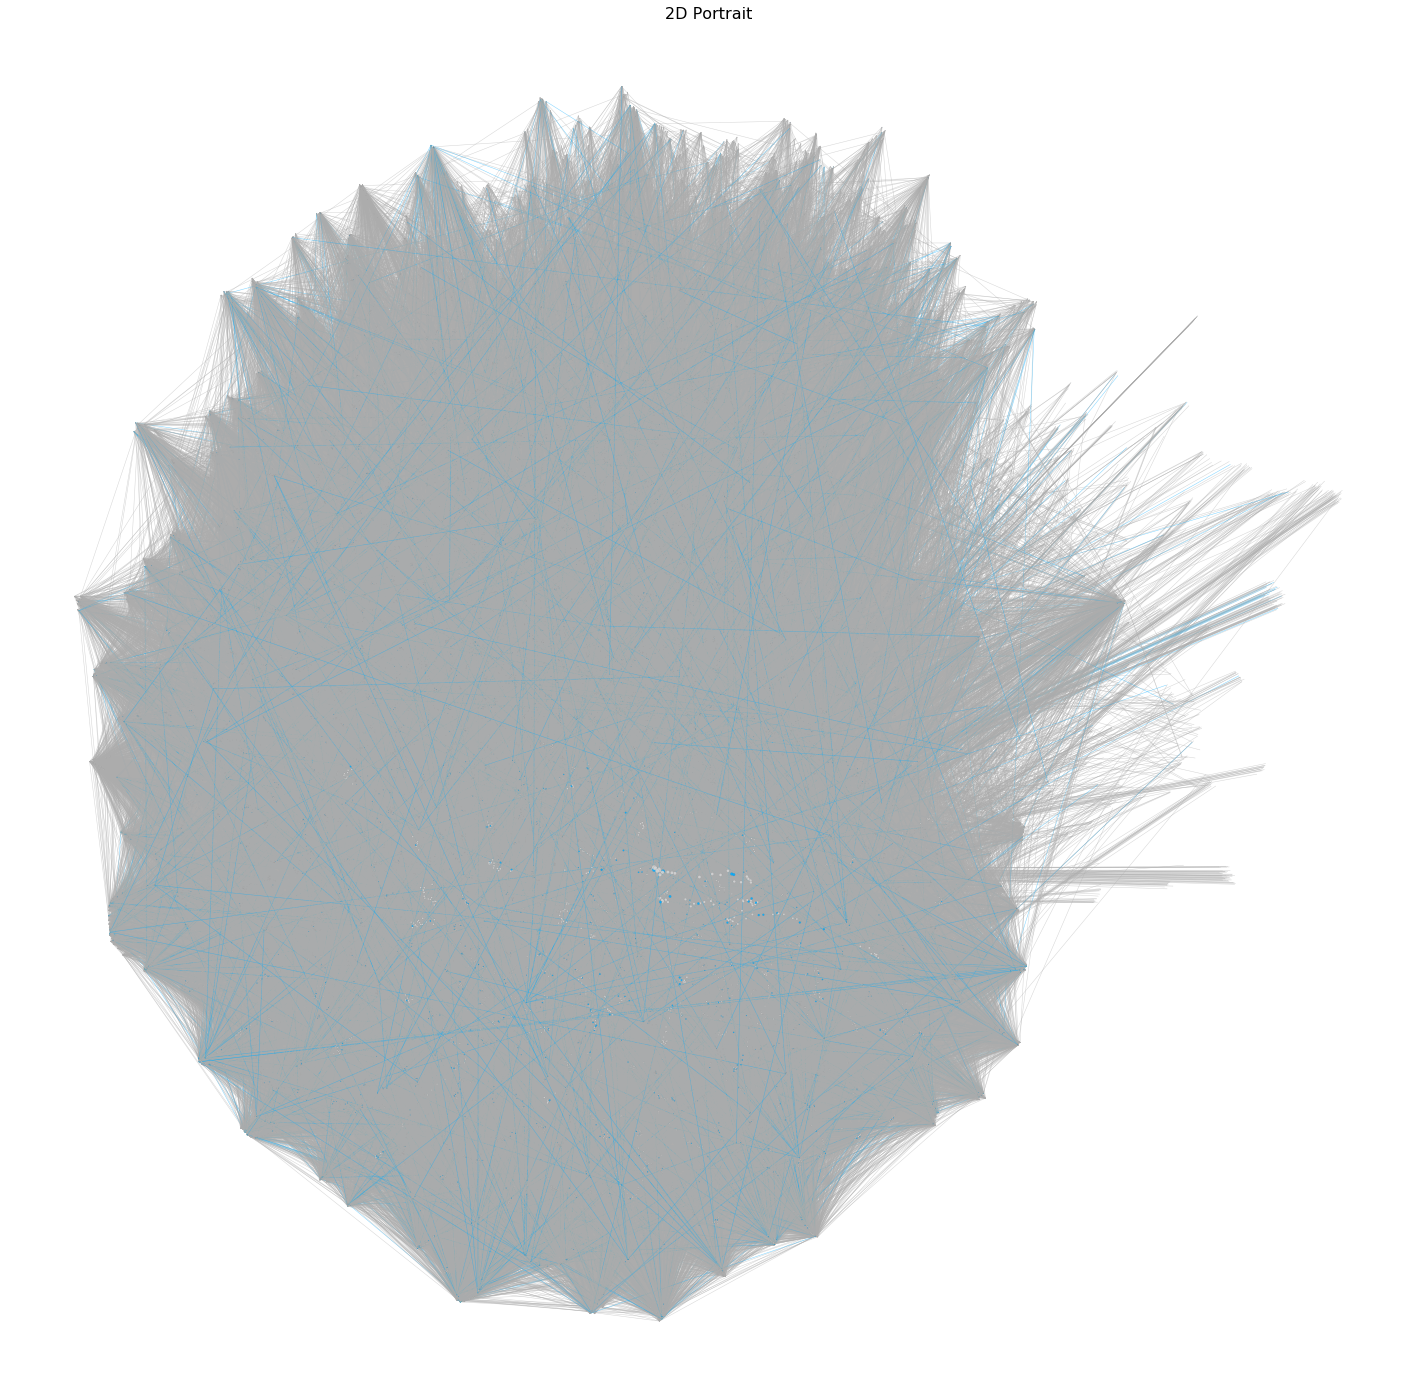

In [21]:
plt.figure(figsize=(25,25))
plt.title('2D Portrait', size=16)

nx.draw_networkx_nodes(G, 
                       posG,
                       edgecolors = 'dimgrey', 
                       linewidths = 0.1, 
                       node_color = colors, 
                       node_size = size, 
                       alpha = 0.9)

nx.draw_networkx_edges(G, posG, width = 0.5, 
                       edge_color = edge_color, 
                      alpha = 0.5)

plt.box(False)

fname = 'output_plots/2Dlayouts/2Dportrait_Fig2a_'+organism

# PNG
#plt.savefig(fname+'.png',dpi=300)

# PDF 
plt.savefig(fname+'.pdf',format='pdf')

plt.show()

### TOPOGRAPHIC MAP 

In [58]:
# ---------------------------------------------------------------------------
#
# Choose a z-parameter e.g. essentiality, centravg, disease 
# or choose any dictionary with nodeID: z-value
# by setting d_z = {nodeID: val, ...}
#
# ---------------------------------------------------------------------------
z_feat = 'disease'
# ---------------------------------------------------------------------------

if z_feat == 'essentiality':

    ''' Essentiality state of each node displayed on layers of "essential", "non-essential", "non-categorized" ''' 

    value_ess = 5
    value_noness = 3 
    value_notdef = 1

    d_ess = {}
    for i in essential_genes:
        d_ess[i] = value_ess
    d_noness = {}
    for i in non_ess_genes:
        d_noness[i] = value_noness
    d_notdef = {}
    for i in notdefined_genes:
        d_notdef[i] = value_notdef

    d_alless_unsort = {**d_ess,**d_noness,**d_notdef}
    d_z = {key:d_alless_unsort[key] for key in G.nodes()}
    
    l_genes = essential_genes
    
    node_col = '#00abff' 
    undefined_col = '#d3d3d3'
    rest_col_nodes = '#d3d3d3'

    d_col_all = color_nodes_from_list(G, essential_genes, node_col)
    colors = list(d_col_all.values())
    
    edge_color = '#ACACAC' 
    d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)
    width_edges = 0.15
    opacity_edges = 0.1
    
    umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size, opacity_nodes)
    umap_edges = get_trace_edges_specific3D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)  
    data = [umap_edges, umap_nodes]
    
    
elif z_feat == 'centravg':
    
    ''' Average of Centrality Metrics displayed in z-height ''' 
    
    d_clos = {}
    for k,v in d_centralities.items():
        d_clos[k] = v[1]

    d_nodecolors = d_clos 
    col_pal = 'YlOrRd'

    d_colors = color_nodes_from_dict(G, d_nodecolors, palette = col_pal)
    colors = list(d_colors.values())
    
    edge_color = '#ACACAC' 
    width_edges = 0.15
    opacity_edges = 0.1
    
    umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size, opacity_nodes)
    umap_edges = get_trace_edges_3D(G, posG, edge_color, opac = 0.05, linewidth = 0.5)
    data = [umap_edges, umap_nodes]
    
    
elif z_feat == 'disease':
    
    ''' Disease count associated to a node displayed in z-height ''' 

    DM_feature  = pd.read_csv('input/Features_Disease_Dataframe_Human.csv', index_col=0)

    # set gene list (= G.nodes())
    genes_assoc = []
    for i in DM_feature.index:
        genes_assoc.append(str(i))

    genes_notassoc = [] 
    for g in G.nodes():
        if g not in genes_assoc:
            genes_notassoc.append(g)

    features_counted = (DM_feature == 1).astype(int).sum(axis=1)
    d_features_counted = dict(zip(genes_assoc, list(features_counted)))
    
    d_rest = {}
    for i in genes_notassoc: 
        d_rest[i] = -20

    d_param_unsorted = {**d_features_counted, **d_rest}
    d_z = {key:d_param_unsorted[key] for key in G.nodes()}
    
    d_clos = {}
    for k,v in d_centralities.items():
        d_clos[k] = v[1]

    d_nodecolors = d_clos 
    col_pal = 'YlOrRd'

    d_colors = color_nodes_from_dict(G, d_nodecolors, palette = col_pal)
    colors = list(d_colors.values())
    edge_color = '#ACACAC'
    width_edges = 0.15
    opacity_edges = 0.1

    umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size, opacity_nodes)
    umap_edges = get_trace_edges_3D(G, posG, edge_color, opac = 0.05, linewidth = 0.5)
    data = [umap_edges, umap_nodes]
    
else:
    pass

#### PLOT 

In [59]:
# ---------------------------------------------------------------------------
#
# Choose a 2D layout as basis
#
# 1. either calculate one e.g.: 
# posG_2Dportrait = layout_portrait_umap(G,DM,2,n_neighbors=20, spread=1, min_dist=0.0, metric='cosine') 
# ---------------------------------------------------------------------------
#
# 2. or use a precalculated 2D layout 
posG_2D = posG_umap2D
# ---------------------------------------------------------------------------

posG = layout_topographic(posG_2D, d_z)

path = 'output_plots/Topographic/'
schema = 'light' #'dark'
fname = 'topographic_z_'+z_feat+'_'+netlayout+'_'+organism+'_'+schema

plot_3D(data,path,fname, schema)

'output_plots/Topographic/topographic_z_disease_local_human_light.html'

### GEODESIC MAP

In [60]:
# ---------------------------------------------------------------------------
#
# Choose a radius-parameter e.g. autocore, essentiality
# or choose any dictionary with nodeID: z-value
# by setting d_radius = {nodeID: val, ...}
#
# ---------------------------------------------------------------------------
r_feat = 'autocore'
# ---------------------------------------------------------------------------


if r_feat == 'autocore':

    # Load Gene Information for Gene lists 
    variants = pd.read_csv('input/julias_variants_mod.txt')
    variant_list = [str(i) for i in list(variants['variants'])]
    variant_sym = pd.read_csv('input/julias_variants_sym.txt')
    genes_sym_list = [str(i) for i in list(variant_sym['variant_sym'])]
    d_gene_sym_variants = dict(zip(variant_list,genes_sym_list))

    df_seeds = pd.read_csv('input/seeds_from_genelists.txt')
    df_seeds.columns = ['seeds']
    df_seeds_z = pd.read_csv('input/seeds_from_zNumbers.txt', sep='\n')
    seeds_list = [str(i) for i in list(df_seeds['seeds'])]

    d_seeds_idsym = {}
    for k,v in d_gene_sym.items():
        for i in seeds_list:
            if v == i:
                d_seeds_idsym[k]=i
    seed_list = list(d_seeds_idsym.keys())

    FM_BP = pd.read_csv('input/Features_GO_BiolProc_Dataframe_human.csv', index_col=0)
    bioproc_list = list(FM_BP.index)

    # From obtained Gene lists select those to be mapped onto different shells 
    # select genes for shells 
    shell_one = variant_list
    shell_two = seed_list
    shell_three = [str(i) for i in bioproc_list]

    small_rad = 1
    mid_rad = 5
    large_rad = 30
    outershell_rad = 50

    d_param = {}
    for i in G.nodes():
        if str(i) in variant_list:
            d_param[str(i)] = small_rad
        elif i in seed_list:
            d_param[str(i)] = mid_rad 
        elif int(i) in bioproc_list:
            d_param[str(i)] = large_rad 
        else:
            d_param[str(i)] = outershell_rad

    d_radius = d_param
    genes_rad = variant_list + seed_list + bioproc_list

    # check how many shells of spheres there will be :
    print('Number of Spherical Shells:', len(set(d_param.values())))


    # Specifying coloring based on genes on different shells 
    d_nodecol = d_clos 
    d_colors = color_nodes_from_dict(G, d_nodecol, palette = col_pal)

    d_colors_spec_genes = {}
    for k,v in d_colors.items():
        if k in shell_one:
            d_colors_spec_genes[k]='#8b0000' 
        elif k in shell_two:
            d_colors_spec_genes[k]='#FF4500' 
        elif k in shell_three:
            d_colors_spec_genes[k]=v
        else: 
            d_colors_spec_genes[k]='#d3d3d3'

    d_colors_spec_genes_sort = {key:d_colors_spec_genes[key] for key in G.nodes()}
    colors = list(d_colors_spec_genes_sort.values())

    
elif r_feat == 'essentiality':

    small_rad = 1
    mid_rad = 10
    outershell_rad = 20

    d_ess_scores = {}
    for i in G.nodes():
        if i in essential_genes:
            d_ess_scores[i] = small_rad
        elif i in non_ess_genes:
            d_ess_scores[i] = mid_rad
        elif str(i) in notdefined_genes:
            d_ess_scores[i] = outershell_rad

    d_radius = d_ess_scores
    genes_rad = list(G.nodes())

    # check how many shells of spheres there will be :
    print('Number of Spherical Shells:', len(set(d_param.values())))

    # Specifying coloring based on genes on different shells 
    d_colors_spec_genes = {}
    for k in G.nodes():
        if k in essential_genes:
            d_colors_spec_genes[k]='#0080bf' 
        elif k in non_ess_genes:
            d_colors_spec_genes[k]='#95dcff' 
        else: 
            d_colors_spec_genes[k]='#d3d3d3'

    d_colors_spec_genes_sort = {key:d_colors_spec_genes[key] for key in G.nodes()}
    colors = list(d_colors_spec_genes_sort.values())
    
    
else: 
    pass

Number of Spherical Shells: 4


#### PLOT 

In [65]:
# ---------------------------------------------------------------------------
#
# SELECT a r - Parameter:
#
# d_radius > a dictionary with keys=G.nodes and values=any radius assigned to each node
# ---------------------------------------------------------------------------

posG_sphere = layout_geodesic(G, d_radius, n_neighbors=20, spread=1, min_dist=0.0)#, DM=DM)
posG = posG_sphere

umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size3d, opacity_nodes)
umap_edges = get_trace_edges_3D(G, posG, edge_color, opac = 0.05, linewidth = 0.5)
data = [umap_nodes]#,umap_edges]

path = 'output_plots/Geodesic/'
schema = 'light' #'dark'
fname = 'geodesic_r_'+r_feat+'_'+netlayout+'_'+organism+'_'+schema

plot_3D(data,path,fname, 'dark')

DM precalc used


'output_plots/Geodesic/geodesic_r_r-autocore_local_human_light.html'